In [1]:
import numpy as np 
import pandas as pd
import seaborn as sn 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_excel("COBRA-YTD2017.xlsx")

In [3]:
data

,MI_PRINX,offense_id,rpt_date,occur_date,occur_time,poss_date,poss_time,beat,apt_office_prefix,apt_office_num,...,dispo_code,MaxOfnum_victims,Shift,Avg Day,loc_type,UC2 Literal,neighborhood,npu,x,y
0,8924155,173650072,12/31/2017,12/30/2017,23:15:00,12/31/2017,00:30:00,510,NaN,NaN,...,NaN,2.0,Morn,Sat,13.0,LARCENY-FROM VEHICLE,Downtown,M,-84.38013,33.75582
1,8924156,173650102,12/31/2017,12/18/2017,13:00:00,12/30/2017,22:00:00,501,NaN,NaN,...,NaN,1.0,Unk,Unk,13.0,LARCENY-FROM VEHICLE,Home Park,E,-84.39745,33.78674
2,8924157,173650144,12/31/2017,12/30/2017,22:01:00,12/31/2017,01:00:00,303,NaN,NaN,...,NaN,1.0,Morn,Sat,18.0,LARCENY-FROM VEHICLE,Mechanicsville,V,-84.39486,33.73760
3,8924158,173650149,12/31/2017,12/30/2017,20:00:00,12/31/2017,01:06:00,507,NaN,NaN,...,NaN,1.0,Eve,Sat,18.0,LARCENY-FROM VEHICLE,Castleberry Hill,M,-84.39887,33.75156
4,8924159,173650159,12/31/2017,12/31/2017,00:41:00,12/31/2017,00:48:00,409,NaN,NaN,...,NaN,2.0,Morn,Sun,18.0,LARCENY-FROM VEHICLE,Adams Park,R,-84.46522,33.72146
5,8924160,173650180,12/31/2017,12/30/2017,23:00:00,12/31/2017,01:26:00,612,NaN,NaN,...,NaN,1.0,Morn,Sun,18.0,LARCENY-FROM VEHICLE,East Atlanta,W,-84.34660,33.74006
6,8924161,173650236,12/31/2017,12/31/2017,01:55:00,12/31/2017,01:59:00,605,NaN,13,...,NaN,1.0,Morn,Sun,26.0,ROBBERY-PEDESTRIAN,Grant Park,W,-84.37373,33.74505
7,8924162,173650241,12/31/2017,12/31/2017,00:00:00,12/31/2017,02:00:00,603,NaN,NaN,...,NaN,1.0,Morn,Sun,18.0,LARCENY-FROM VEHICLE,Old Fourth Ward,M,-84.37190,33.77303
8,8924163,173650295,12/31/2017,12/30/2017,00:00:00,12/31/2017,03:02:00,605,NaN,NaN,...,NaN,1.0,Unk,Sat,13.0,LARCENY-FROM VEHICLE,Grant Park,W,-84.37285,33.74639
9,8924164,173650389,12/31/2017,12/31/2017,00:00:00,12/31/2017,03:34:00,304,NaN,8,...,NaN,1.0,Morn,Sun,26.0,BURGLARY-RESIDENCE,Peoplestown,V,-84.38625,33.72579


In [20]:
#rough map of crime density 
#filter x and y first to remove NaN and Zero 
x = data['x']
y = data['y']

x = x[x != 0]
y = y[y != 0]

x = x.astype('float')
y = y.astype('float')

x = x.values
y = y.values


In [82]:
#Generate 2D Histogram in Numpy 
H, xedges, yedges = np.histogram2d(x, y, bins=1000) 

#get centers for x and y 
xc = (xedges[1:] + xedges[:-1])/2 
yc = (yedges[1:] + yedges[:-1])/2 

#Flatten 
entries = np.zeros((xc.shape[0] * yc.shape[0], 3)) 
for i in range(0, xc.shape[0]): 
    for j in range(0, yc.shape[0]): 
        entries[i * yc.shape[0] + j, 1] = xc[i]
        entries[i * yc.shape[0] + j, 0] = yc[j] 
        entries[i * yc.shape[0] + j, 2] = H[i, j]

In [89]:
#Process Entries using a filter 
#we'll take a square of 11x11, and use a normalized sum pool
def apply_filter(x, y, H, FILTER_SIZE = 15): 
    total = H.sum() 

    patched = np.zeros((H.shape[0] - FILTER_SIZE, H.shape[1] - FILTER_SIZE)) 
    xr = x[FILTER_SIZE//2:-FILTER_SIZE//2]
    yr = y[FILTER_SIZE//2:-FILTER_SIZE//2]
    #filter 
    for i in range(FILTER_SIZE//2, H.shape[0] - (FILTER_SIZE//2 + 1)): 
        for j in range(FILTER_SIZE//2, H.shape[1] - (FILTER_SIZE//2 + 1)): 
            sumPool = H[i-FILTER_SIZE//2:i+FILTER_SIZE//2 + 1,j-FILTER_SIZE:j+FILTER_SIZE//2 + 1].sum() 
            patched[i - FILTER_SIZE//2, j - FILTER_SIZE//2] = sumPool
    return (xr, yr, patched)
R1 = apply_filter(xc, yc, H)
R2 = apply_filter(*R1) 
R3 = apply_filter(*R2)

In [91]:
def dumpToJSONDataFile(x, y, H): 
    import json
    jsonDict = {"x": x.tolist(), "y": y.tolist(), "z": H.tolist()}; 
    with open("data.json", 'w') as f: 
        json.dump(jsonDict, f)

In [92]:
dumpToJSONDataFile(*R2)

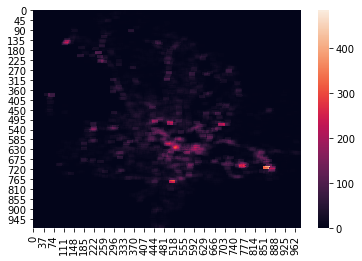

In [84]:
sn.heatmap(p1)

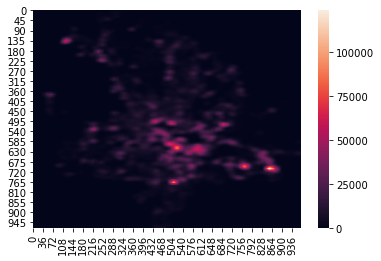

In [85]:
sn.heatmap(p2)

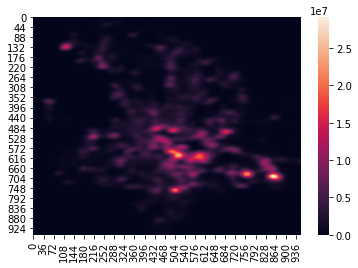

In [86]:
sn.heatmap(p3)

In [50]:
a = np.array([1, 2, 3])

In [55]:
",".join(map(str,a.tolist()))

'1,2,3'

In [68]:
y.mean(), x.mean()

(33.759367852108696, -84.40725656201711)